In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome python-dotenv
clear_output()

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation, genome, track_data, transcript
from alphagenome.data.track_data import TrackData
from alphagenome.models import dna_client
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
ALPHA_GENOME_API_KEY = os.environ["ALPHAGENOME_API_KEY"]
dna_model = dna_client.create(ALPHA_GENOME_API_KEY)
# dna_model = dna_client.create(colab_utils.get_api_key())

# Load metadata objects for human.
output_metadata = dna_model.output_metadata(
    organism=dna_client.Organism.HOMO_SAPIENS
)


import pandas as pd
import requests

# 파일 경로 설정
url = 'https://storage.googleapis.com/alphagenome/reference/gencode/hg38/gencode.v46.annotation.gtf.gz.feather'
local_filename = 'gencode.v46.annotation.gtf.gz.feather'

# 1. 파일이 없으면 다운로드 (최초 1회만 실행됨)
if not os.path.exists(local_filename):
    print(f"Downloading {local_filename}...")
    response = requests.get(url)
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
else:
    print("File already exists. Loading from local disk.")

# 2. 로컬 파일에서 읽기 (이제 빠릅니다!)
gtf = pd.read_feather(local_filename)
print("Data loaded!")


# # Load gene annotations (from GENCODE).
# gtf = pd.read_feather(
#     'https://storage.googleapis.com/alphagenome/reference/gencode/'
#     'hg38/gencode.v46.annotation.gtf.gz.feather'
# )

# Filter to protein-coding genes and highly supported transcripts.
gtf_transcript = gene_annotation.filter_transcript_support_level(
    gene_annotation.filter_protein_coding(gtf), ['1']
)

# Extractor for identifying transcripts in a region.
transcript_extractor = transcript.TranscriptExtractor(gtf_transcript)

# Also define an extractor that fetches only the longest transcript per gene.
gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
    gtf_transcript
)
longest_transcript_extractor = transcript.TranscriptExtractor(
    gtf_longest_transcript
)

Download complete.
Data loaded!


In [4]:
gene_dict = {
    "PTEN":    {"id": "ENSG00000171862", "type": "Coding",    "status": "Real",   "sequence": None},
    "PTENP1":  {"id": "ENSG00000237938", "type": "Noncoding", "status": "Pseudo", "sequence": None},
    "GAPDH":   {"id": "ENSG00000111640", "type": "Coding",    "status": "Real",   "sequence": None},
    "GAPDHP1": {"id": "ENSG00000228232", "type": "Noncoding", "status": "Pseudo", "sequence": None},
    "HBB":     {"id": "ENSG00000244734", "type": "Coding",    "status": "Real",   "sequence": None},
    "H19":     {"id": "ENSG00000130600", "type": "Noncoding", "status": "Real",   "sequence": None},
    "RPS29":   {"id": "ENSG00000145592", "type": "Coding",    "status": "Real",   "sequence": None},
    "GAS5":    {"id": "ENSG00000234741", "type": "Noncoding", "status": "Real",   "sequence": None},
    "TP53":    {"id": "ENSG00000141510", "type": "Coding",    "status": "Real",   "sequence": None},
    "SNHG1":   {"id": "ENSG00000237699", "type": "Noncoding", "status": "Real",   "sequence": None}
}

for k, v in gene_dict.items():
    ensemblID=v["id"]
    print(f"gene name: {k:<10} ensembl ID: {ensemblID}")

gene name: PTEN       ensembl ID: ENSG00000171862
gene name: PTENP1     ensembl ID: ENSG00000237938
gene name: GAPDH      ensembl ID: ENSG00000111640
gene name: GAPDHP1    ensembl ID: ENSG00000228232
gene name: HBB        ensembl ID: ENSG00000244734
gene name: H19        ensembl ID: ENSG00000130600
gene name: RPS29      ensembl ID: ENSG00000145592
gene name: GAS5       ensembl ID: ENSG00000234741
gene name: TP53       ensembl ID: ENSG00000141510
gene name: SNHG1      ensembl ID: ENSG00000237699


In [5]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path.cwd()
if BASE_DIR.name == 'dna-fm-to-alphagenome':
    BASE_DIR = BASE_DIR.parent

SEQ_ROOT = BASE_DIR / 'dna-model-collapse' / 'results' / 'sequences'
GENE_LENGTH = dna_client.SEQUENCE_LENGTH_16KB


def get_sequence(gene, model, strategy="sampling_t1.0"):
    csv_path = SEQ_ROOT / model / f'{gene}.csv'
    if not csv_path.exists():
        raise FileNotFoundError(f'Missing sequence CSV: {csv_path}')
    df = pd.read_csv(csv_path, index_col=0)
    if strategy not in df.index:
        raise KeyError(f'Strategy not found: {strategy}')
    last_col = df.columns[-1]
    return df.loc[strategy, last_col]

def compare_wt_and_gen_value(gene_dict=gene_dict, models=("DNABERT-2", "NT-v2-500m"), strategy="sampling_t1.0"):

    def format_term(term):
        if term is None:
            return None
        term_type = getattr(term, 'type', None)
        term_id = getattr(term, 'id', None)
        type_name = None
        if term_type is not None:
            type_name = getattr(term_type, 'name', None)
            if not type_name:
                type_str = str(term_type)
                if '.' in type_str:
                    type_name = type_str.split('.')[-1].split(':')[0]
        if type_name and term_id is not None:
            try:
                return f"{type_name}:{int(term_id):07d}"
            except Exception:
                pass
        return str(term)

    # def best_term_and_value(rna_seq_output):
    #     terms = rna_seq_output.ontology_terms
    #     vals = rna_seq_output.values
    #     # track_max = vals.max(axis=0)
    #     track_max = vals.max(axis=0).max()

    #     by_term = {}
    #     for term, m in zip(terms, track_max):
    #         if term is None:
    #             continue
    #         by_term[term] = max(by_term.get(term, -float("inf")), float(m))
    #     best_term = max(by_term, key=by_term.get)
    #     best_value = by_term[best_term]
    #     return format_term(best_term), best_value

    def best_term_and_value(rna_seq_output):
        terms = rna_seq_output.ontology_terms
        vals = rna_seq_output.values
        meta = rna_seq_output.metadata

        # Keep both total RNA-seq and polyA plus RNA-seq (all strands)
        assay_mask = meta["Assay title"].isin(["total RNA-seq", "polyA plus RNA-seq"]).to_numpy()
        if assay_mask.any():
            vals = vals[:, assay_mask]
            terms = [t for t, keep in zip(terms, assay_mask) if keep]

        # term(열)별 최대값
        track_max = vals.max(axis=0)

        # term별 최대값 중 가장 큰 것
        best_idx = int(track_max.argmax())
        best_term = terms[best_idx]
        best_value = float(track_max[best_idx])

        return format_term(best_term), best_value


    rows = []
    for gene, value in gene_dict.items():
        ensemblID = value["id"]
        wt_interval = gene_annotation.get_gene_interval(gtf, gene_id=ensemblID).resize(GENE_LENGTH)

        wt_output = dna_model.predict_interval(
            interval=wt_interval,
            requested_outputs={dna_client.OutputType.RNA_SEQ, dna_client.OutputType.CAGE},
            ontology_terms=None
        )
        wt_term, wt_value = best_term_and_value(wt_output.rna_seq)

        row = {
            "gene": gene,
            "wt_term": wt_term,
            "wt_value": wt_value,
        }

        for model in models:
            seq_gen = get_sequence(gene, model, strategy)
            gen_output = dna_model.predict_sequence(
                sequence=seq_gen.center(GENE_LENGTH, 'N'),
                requested_outputs={dna_client.OutputType.RNA_SEQ, dna_client.OutputType.CAGE},
                ontology_terms=None
            )
            gen_term, gen_value = best_term_and_value(gen_output.rna_seq)
            row[f"{model}_term"] = gen_term
            row[f"{model}_value"] = gen_value
            row[f"{model}_term_changed"] = wt_term != gen_term
            row[f"{model}_value_delta"] = gen_value - wt_value
            row[f"{model}_value_pct"] = (gen_value - wt_value) / wt_value * 100 if wt_value else None

        rows.append(row)

    return pd.DataFrame(rows)


In [6]:
compare_df = compare_wt_and_gen_value(models=("DNABERT-2", "NT-v2-500m"))
compare_df


,gene,wt_term,wt_value,DNABERT-2_term,DNABERT-2_value,DNABERT-2_term_changed,DNABERT-2_value_delta,DNABERT-2_value_pct,NT-v2-500m_term,NT-v2-500m_value,NT-v2-500m_term_changed,NT-v2-500m_value_delta,NT-v2-500m_value_pct
0,PTEN,CL:2000040,0.628906,UBERON:0000473,0.345703,True,-0.283203,-45.031056,CL:0000899,0.539062,True,-0.089844,-14.285714
1,PTENP1,UBERON:0002037,7.531250,UBERON:0000473,0.212891,True,-7.318359,-97.173237,UBERON:0000473,0.244141,True,-7.287109,-96.758299
2,GAPDH,EFO:0002824,552.000000,EFO:0002103,0.068359,True,-551.931641,-99.987616,EFO:0002713,0.882812,True,-551.117188,-99.840070
3,GAPDHP1,EFO:0000572,4.093750,UBERON:0009834,0.068359,True,-4.025391,-98.330153,CL:0000679,0.162109,True,-3.931641,-96.040076
4,HBB,UBERON:0006920,86.500000,EFO:0007950,0.273438,True,-86.226562,-99.683887,UBERON:0000473,0.058594,True,-86.441406,-99.932262
5,H19,UBERON:0002324,102.000000,CL:0000837,0.129883,True,-101.870117,-99.872664,UBERON:0000473,0.067383,True,-101.932617,-99.933938
6,RPS29,EFO:0002784,768.000000,UBERON:0002331,0.021851,True,-767.978149,-99.997155,UBERON:0000473,0.867188,True,-767.132812,-99.887085
7,GAS5,EFO:0002067,103.500000,EFO:0002103,0.273438,True,-103.226562,-99.735809,EFO:0005725,1.953125,True,-101.546875,-98.112923
8,TP53,EFO:0007950,9.250000,EFO:0002103,0.066895,True,-9.183105,-99.276816,UBERON:0001114,1.554688,True,-7.695312,-83.192568
9,SNHG1,UBERON:0000473,0.664062,EFO:0007950,0.118164,True,-0.545898,-82.205882,EFO:0007950,0.066406,True,-0.597656,-90.000000


In [7]:
table_df = compare_df[["gene", "wt_value", "DNABERT-2_value", "DNABERT-2_value_pct", "NT-v2-500m_value",  "NT-v2-500m_value_pct"]]
table_df = table_df.rename(columns={
    "gene": "Gene",
    "wt_value": "Ori_value",
    "DNABERT-2 value": "DNABERT-2_value",
    "NT-v2-500m value": "NT_value",
    "DNABERT-2 value_pct": "DNABERT-2_pct",
    "NT-v2-500m value_pct": "NT_pct",
})
table_df


,Gene,Ori_value,DNABERT-2_value,DNABERT-2_value_pct,NT-v2-500m_value,NT-v2-500m_value_pct
0,PTEN,0.628906,0.345703,-45.031056,0.539062,-14.285714
1,PTENP1,7.531250,0.212891,-97.173237,0.244141,-96.758299
2,GAPDH,552.000000,0.068359,-99.987616,0.882812,-99.840070
3,GAPDHP1,4.093750,0.068359,-98.330153,0.162109,-96.040076
4,HBB,86.500000,0.273438,-99.683887,0.058594,-99.932262
5,H19,102.000000,0.129883,-99.872664,0.067383,-99.933938
6,RPS29,768.000000,0.021851,-99.997155,0.867188,-99.887085
7,GAS5,103.500000,0.273438,-99.735809,1.953125,-98.112923
8,TP53,9.250000,0.066895,-99.276816,1.554688,-83.192568
9,SNHG1,0.664062,0.118164,-82.205882,0.066406,-90.000000


In [8]:
#TODO
"""
1. PTEN, NT-v2-500m 시각화
2. ontology term change false 난것도 시각화
3. 왜 이렇게 되었을지 고민해보기: 왜 다들 이렇게 처참하게 무너졌으며, 그와중에 혼자 값이 튀는 애는 뭐고 등등...
4. 특히 저 NT-v2-500m PTEN은 similarity나 이런 걸 좀 더 봐야겠는데?
5. 폴더 분리: 여기에 alphagenome api key 있어서 git에 올리더라도 private으로 올려야 함. 아니면 dna-model-collapse에서 sequence랑 embedding 만드는 부분만 따로 public으로 올려도 될 거 같은데
그러니까 파일 구분을 gen-seq-emb 하나, dna-model-collapse(visualization 하는거) 하나, alphagenome으로 비교하는 거 하나 이렇게 셋으로 나누는게 깔끔할 거 같음
"""

'\n1. PTEN, NT-v2-500m 시각화\n2. ontology term change false 난것도 시각화\n3. 왜 이렇게 되었을지 고민해보기: 왜 다들 이렇게 처참하게 무너졌으며, 그와중에 혼자 값이 튀는 애는 뭐고 등등...\n4. 특히 저 NT-v2-500m PTEN은 similarity나 이런 걸 좀 더 봐야겠는데?\n5. 폴더 분리: 여기에 alphagenome api key 있어서 git에 올리더라도 private으로 올려야 함. 아니면 dna-model-collapse에서 sequence랑 embedding 만드는 부분만 따로 public으로 올려도 될 거 같은데\n그러니까 파일 구분을 gen-seq-emb 하나, dna-model-collapse(visualization 하는거) 하나, alphagenome으로 비교하는 거 하나 이렇게 셋으로 나누는게 깔끔할 거 같음\n'

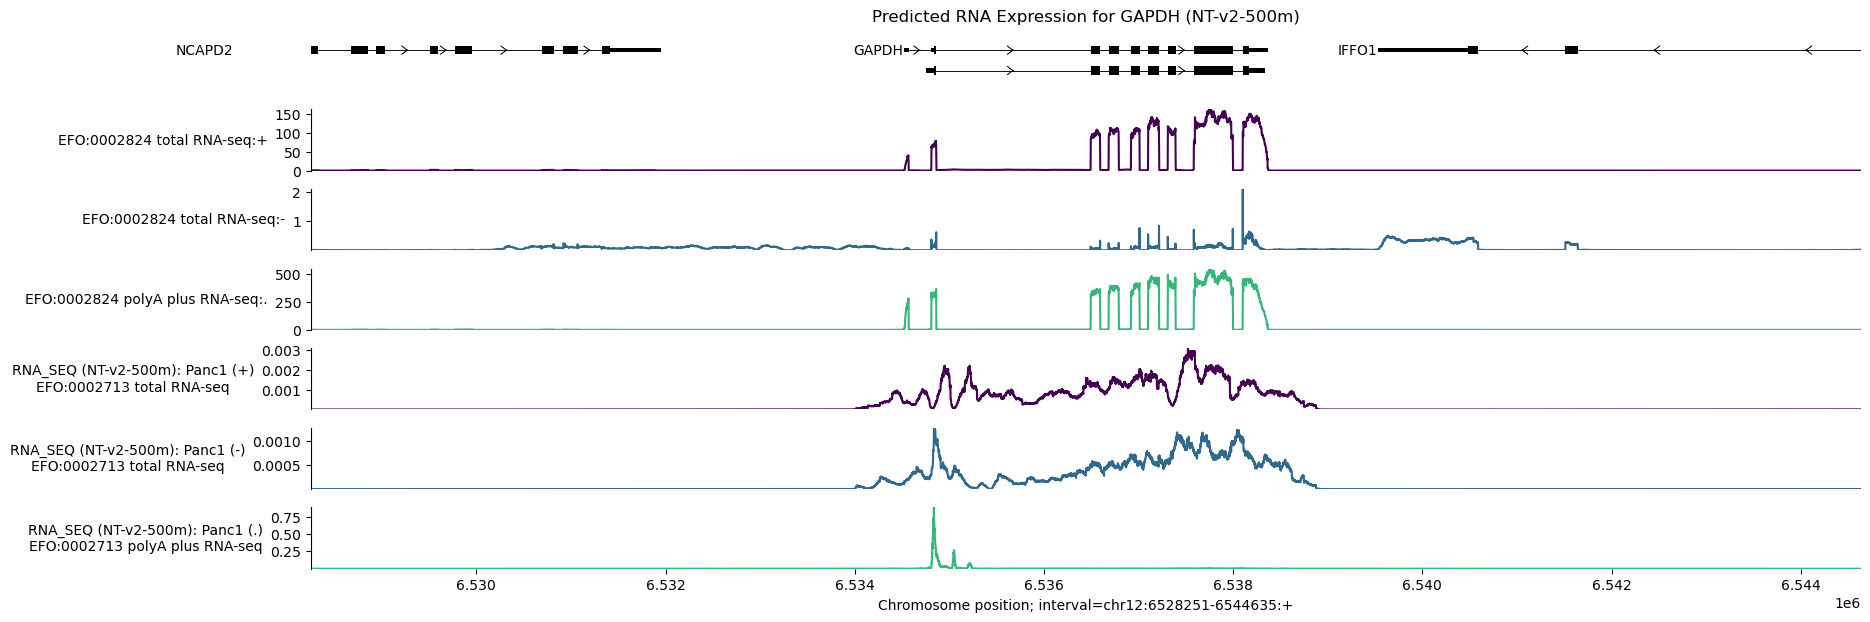

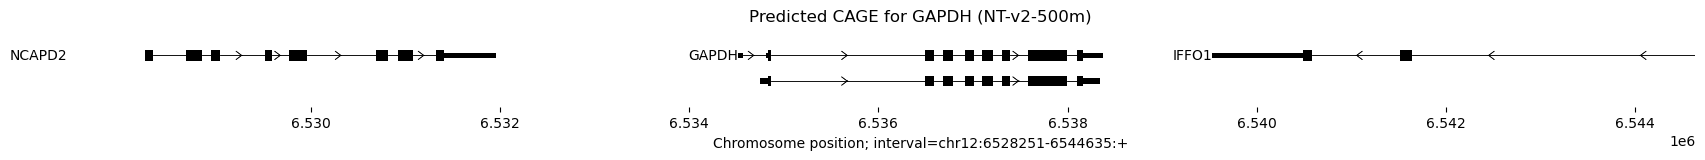

In [ ]:
GENE_NAME = "GAPDH"
MODEL = "NT-v2-500m"
STRATEGY = "sampling_t1.0"
# ONTOLOGY_TERMS = None  # e.g. ["CL:0002618"]
ONTOLOGY_TERMS = ["EFO:0002824"]

ENSEMBL_ID = gene_dict[GENE_NAME]["id"]
# INTERVAL = gene_annotation.get_gene_interval(gtf, gene_id=ENSEMBL_ID).resize(GENE_LENGTH)
INTERVAL = gene_annotation.get_gene_interval(gtf, gene_symbol=GENE_NAME).resize(GENE_LENGTH)

longest_transcripts = transcript_extractor.extract(INTERVAL)

wt_output = dna_model.predict_interval(
    interval=INTERVAL,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ, 
        dna_client.OutputType.CAGE,
        },
    ontology_terms=ONTOLOGY_TERMS,
    # ontology_terms=["EFO:0002784"],
)

seq_gen = get_sequence(gene=GENE_NAME, model=MODEL, strategy=STRATEGY).center(GENE_LENGTH, "N")

gen_output = dna_model.predict_sequence(
    sequence=seq_gen,
    requested_outputs={dna_client.OutputType.RNA_SEQ, dna_client.OutputType.CAGE,},
    ontology_terms=["EFO:0002713	"],
)

gen_rna_seq = TrackData(
    values=gen_output.rna_seq.values,
    metadata=gen_output.rna_seq.metadata,
    interval=INTERVAL,
)

gen_cage = TrackData(
    values=gen_output.cage.values,
    metadata=gen_output.cage.metadata,
    interval=INTERVAL,
)

plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            wt_output.rna_seq,
        ),
        plot_components.Tracks(
            tdata=gen_rna_seq,
            ylabel_template=f'RNA_SEQ ({MODEL}): {{biosample_name}} ({{strand}})\n{{name}}',
        ),
    ],
    interval=INTERVAL,
    title=f'Predicted RNA Expression for {GENE_NAME} ({MODEL})',
)

plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            wt_output.cage,
        ),
        plot_components.Tracks(
            tdata=gen_cage,
            ylabel_template=f'CAGE ({MODEL}): {{biosample_name}} ({{strand}})\n{{name}}',
        ),
    ],
    interval=INTERVAL,
    title=f'Predicted CAGE for {GENE_NAME} ({MODEL})',
)

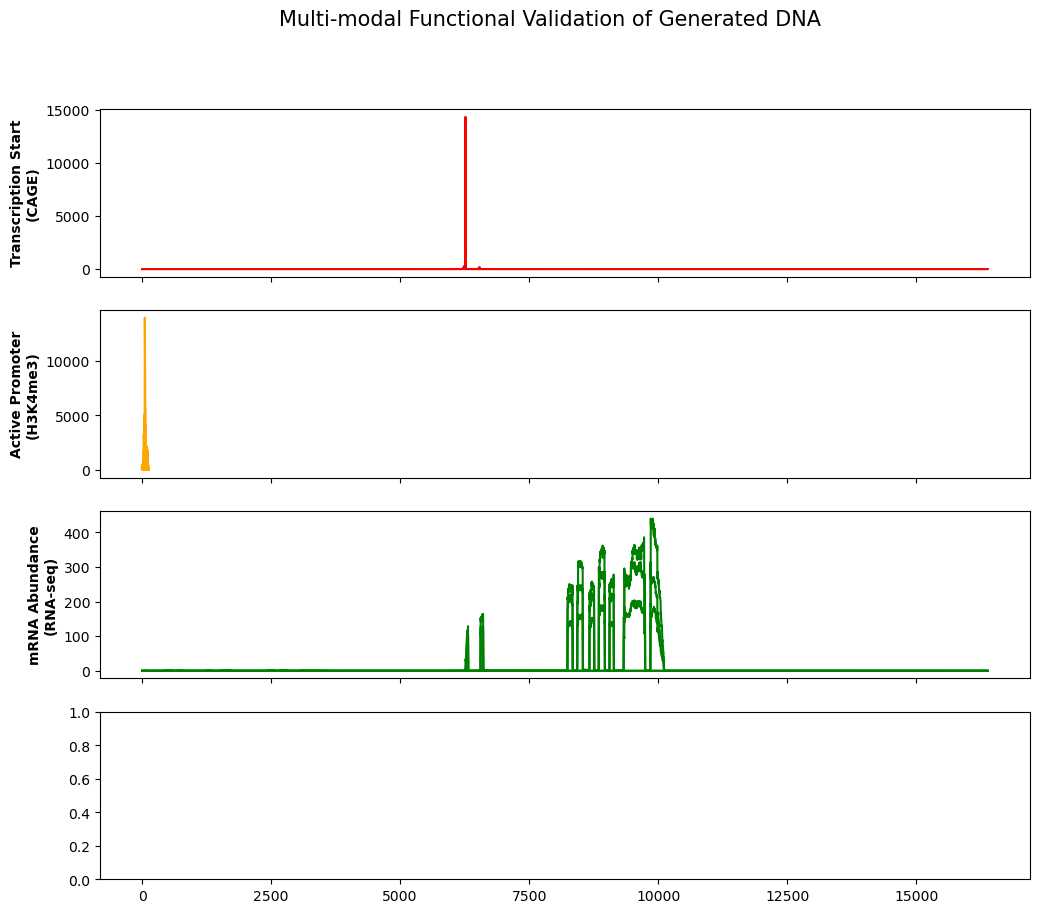

In [44]:
# 1. Output 설정: RNA-seq 외에 CAGE, Histone, Splicing 추가
requested_outputs = {
    dna_client.OutputType.RNA_SEQ,        # 기본 (Expression)
    dna_client.OutputType.CAGE,           # 전사 개시 (Initiation)
    dna_client.OutputType.CHIP_HISTONE,   # 크로마틴 구조 (Promoter Mark)
    dna_client.OutputType.SPLICE_JUNCTIONS # 스플라이싱 정확도 (Structure)
}

# 2. 예측 실행
ref_output = dna_model.predict_interval(
    interval=INTERVAL, # 반드시 1MB 권장
    requested_outputs=requested_outputs,
    ontology_terms=["EFO:0002067"] # K562 (가장 신호가 뚜렷함)
)

# gen_output = dna_model.predict_sequence(
#     sequence=seq_gen,
#     requested_outputs=requested_outputs,
#     ontology_terms=["EFO:0002713	"],
# )

# 3. 데이터 추출 및 시각화 (개념 코드)
import matplotlib.pyplot as plt

# 트랙 데이터 가져오기 (함수/변수명은 실제 객체 구조에 맞게 조정)
# 예: CHIP_HISTONE 중에서도 'H3K4me3'가 포함된 트랙을 찾아야 함
track_cage = getattr(ref_output, "cage")
track_h3k4 = getattr(ref_output, "chip_histone") # CHIP_HISTONE 내부 검색
track_rna  = getattr(ref_output, "rna_seq")
track_splice = getattr(ref_output, "splice_sites")

# 4. 4단 콤보 플롯 그리기
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# [Plot 1] CAGE: 뾰족한 피크가 떠야 함 (Start Site)
axes[0].plot(track_cage, color='red')
axes[0].set_ylabel("Transcription Start\n(CAGE)", fontweight='bold')

# [Plot 2] H3K4me3: 넓은 산 모양이 떠야 함 (Active Promoter)
axes[1].plot(track_h3k4, color='orange')
axes[1].set_ylabel("Active Promoter\n(H3K4me3)", fontweight='bold')

# [Plot 3] RNA-seq: 전체적으로 높게 나와야 함 (Expression)
axes[2].plot(track_rna, color='green')
axes[2].set_ylabel("mRNA Abundance\n(RNA-seq)", fontweight='bold')

# # [Plot 4] Splicing: 엑손 경계에서만 튀어야 함
# axes[3].plot(track_splice, color='blue')
# axes[3].set_ylabel("Splice Junctions", fontweight='bold')

plt.suptitle("Multi-modal Functional Validation of Generated DNA", fontsize=15)
plt.show()

In [20]:
vals = wt_output.rna_seq.values
meta = wt_output.rna_seq.metadata

track_max = vals.max(axis=0)
import pandas as pd
pd.DataFrame({
    "name": meta["name"],
    "assay": meta["Assay title"],
    "strand": meta["strand"],
    "max": track_max,
}).sort_values("max", ascending=False)


,name,assay,strand,max
0,CL:2000040 total RNA-seq,total RNA-seq,+,0.628906
1,CL:2000040 total RNA-seq,total RNA-seq,-,0.002640


In [21]:
# compare_df 계산에 사용한 것과 동일한 rna_seq인지 확인
rna = wt_output.rna_seq  # compare_df에서 쓴 것과 동일해야 함
vals = rna.values
meta = rna.metadata

print(vals.shape, meta.shape)
print(meta[["name","Assay title","strand"]])
print(vals.max(axis=0))
print(vals.max())  # 전역 최대


(16384, 2) (2, 12)
                       name    Assay title strand
0  CL:2000040 total RNA-seq  total RNA-seq      +
1  CL:2000040 total RNA-seq  total RNA-seq      -
[0.62890625 0.00263977]
0.62890625


In [22]:
vals_p = gen_rna_seq.values
meta_p = gen_rna_seq.metadata
track_max_p = vals_p.max(axis=0)

pd.DataFrame({
    "name": meta_p["name"],
    "assay": meta_p["Assay title"],
    "strand": meta_p["strand"],
    "max": track_max_p,
}).sort_values("max", ascending=False)


,name,assay,strand,max
0,CL:0000899 total RNA-seq,total RNA-seq,+,0.539062
1,CL:0000899 total RNA-seq,total RNA-seq,-,0.178711


In [23]:
wt_output.rna_seq.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,nonzero_mean
0,CL:2000040 total RNA-seq,+,total RNA-seq,CL:2000040,bladder microvascular endothelial cell,primary_cell,adult,,encode,paired,False,0.108766
1,CL:2000040 total RNA-seq,-,total RNA-seq,CL:2000040,bladder microvascular endothelial cell,primary_cell,adult,,encode,paired,False,0.108766


In [24]:
mask = gen_rna_seq.metadata["Assay title"].eq("total RNA-seq").to_numpy()
total_rna_seq = gen_rna_seq.filter_tracks(mask)


# 확인
total_rna_seq.metadata


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,nonzero_mean
0,CL:0000899 total RNA-seq,+,total RNA-seq,CL:0000899,T-helper 17 cell,primary_cell,adult,,encode,single,False,0.159649
1,CL:0000899 total RNA-seq,-,total RNA-seq,CL:0000899,T-helper 17 cell,primary_cell,adult,,encode,single,False,0.159649


In [30]:
# Diagnostics: ensure compare_df and plotted outputs use identical rna_seq
def debug_rna_seq(label, rna):
    vals = rna.values
    meta = rna.metadata
    track_max = vals.max(axis=0)
    print(f"[{label}] vals shape={vals.shape}, terms={len(rna.ontology_terms)}")
    print(meta[['name','Assay title','strand']])
    print('track_max:', track_max)
    print('global_max:', float(vals.max()))
    return track_max

# Use the exact objects used in compare_df and plotting
# Replace these with the actual variables in your notebook if different
_ = debug_rna_seq('compare_df_wt', wt_output.rna_seq)
_ = debug_rna_seq('compare_df_gen', gen_output.rna_seq)

# If you plotted a filtered track (e.g., total_rna_seq), check it too
try:
    _ = debug_rna_seq('plot_total_rna_seq', total_rna_seq)
except NameError:
    print('[plot_total_rna_seq] not defined in this notebook scope')

# If you plotted a custom TrackData like gen_rna_seq, check it too
try:
    _ = debug_rna_seq('plot_gen_rna_seq', gen_rna_seq)
except NameError:
    print('[plot_gen_rna_seq] not defined in this notebook scope')


[compare_df_wt] vals shape=(16384, 3), terms=3
                             name         Assay title strand
0       EFO:0002824 total RNA-seq       total RNA-seq      +
1       EFO:0002824 total RNA-seq       total RNA-seq      -
2  EFO:0002824 polyA plus RNA-seq  polyA plus RNA-seq      .
track_max: [163.         2.109375 552.      ]
global_max: 552.0
[compare_df_gen] vals shape=(16384, 3), terms=3
                             name         Assay title strand
0       EFO:0002713 total RNA-seq       total RNA-seq      +
1       EFO:0002713 total RNA-seq       total RNA-seq      -
2  EFO:0002713 polyA plus RNA-seq  polyA plus RNA-seq      .
track_max: [0.00306702 0.00128174 0.8828125 ]
global_max: 0.8828125
[plot_total_rna_seq] vals shape=(16384, 2), terms=2
                       name    Assay title strand
0  CL:0000899 total RNA-seq  total RNA-seq      +
1  CL:0000899 total RNA-seq  total RNA-seq      -
track_max: [0.5390625  0.17871094]
global_max: 0.5390625
[plot_gen_rna_seq] vals sh